# Using PyTorch feed forward NN to performe regression

Document structure:

We start by performing learning on a simple dataset without any hyperparameter tuning. We then performe parameter tuning and moves on to a more complex dataset.

## Import libraries and classes

In [4]:
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from torch import nn, optim, tensor
from Neural_Network_with_PyTorch import Neural_Network_PyTorch

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model

from tqdm import tqdm
from copy import deepcopy

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

## Solving the regression problem

##### Support functions

In [1]:
def plot_heatmap(values, x_ticks, y_ticks, x_label, y_label, title):
    fig, ax = plt.subplots(figsize = (6, 5))
    heatmap = sns.heatmap(values, annot=True, ax=ax, cmap="viridis")
    heatmap.set_xticklabels(x_ticks)
    heatmap.set_yticklabels(y_ticks)
    ax.set_title(title)
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)
    plt.show()

In [2]:
def make_design_matrix(x, degree):
    "Creates the design matrix for the given polynomial degree and ijnput data"
    
    X = torch.zeros((len(x), degree+1))
    
    for i in range(X.shape[1]):
        X[:,i] = torch.pow(x, i)
        
    return X

#### Generate data 

In [5]:
true_a = torch.tensor([2, 0.5, 3.2])

n = 1000

x = torch.linspace(0, 1, n)
X_OLS = make_design_matrix(x, 2)
x = x.reshape(-1, 1)
target = ((torch.tensor([true_a[0] + true_a[1]*x + true_a[2]*x**2 for x in x]) + .5 * torch.randn(n)) * 1e-1).reshape(-1, 1)


print('Dimensions of input:', x.shape)
print('Dimensions of target:', target.shape)
print('Dimensions of design matrix:', X_OLS.shape)

Dimensions of input: torch.Size([1000, 1])
Dimensions of target: torch.Size([1000, 1])
Dimensions of design matrix: torch.Size([1000, 3])


Above we see the size of the generated data. We now note that there is no design matrix used in the instance of a NN. The whole point is to let the neuaral network "choose" the connections through the training. 

Next up we need to split the data into training and test data. Lastly we display the target values in their respective groups.  

Creating the training and test data

In [6]:
train_X, test_X, train_X_OLS, test_X_OLS, train_target, test_target = train_test_split(x, X_OLS, target, test_size=0.2)

In [7]:
train_target = train_target.reshape(-1, 1)
test_target = test_target.reshape(-1, 1)

Displaying the target values in their respective groups

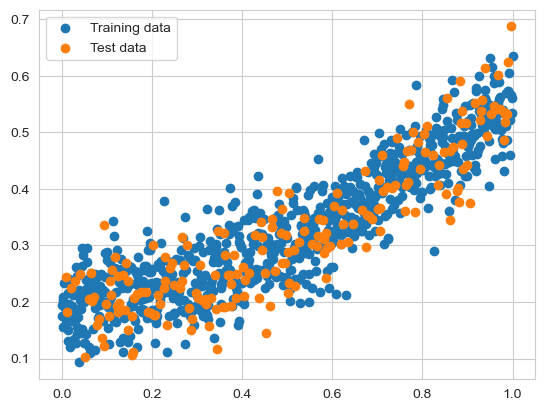

In [8]:
plt.figure()
plt.scatter(train_X[:,0], train_target, label='Training data')
plt.scatter(test_X[:,0], test_target, label='Test data')
plt.legend()

#### Initializing the model

We now initialize the model. We start with a randomly selected model architecture w.r.t. number of hidden layers, number of hidden nodes. For the input dimention we use the number of predictors from X i.e. the polynomial degree + 1 (for the intercept). For the output dimension we use the number of parameters in the true_a. For the activation function we use ReLU for the hidden layers and linear for the output layer, the latter is done since we are performing a regression analysis and not a classification.

In [9]:
# Network design
n_inputs = train_X.shape[1]
n_hidden_layers = 2
n_hidden_nodes = 4
n_outputs = 1

# Create network
ffnn = Neural_Network_PyTorch(n_inputs, 
                              n_hidden_layers, n_hidden_nodes, 
                              n_outputs, 
                              activation_function_hidden_layers='sigmoid', 
                              activation_function_output_layer=None) # Linear activation function for output layer since we are doing regression

print('Model parameters:')
print(ffnn.hidden0)
print(ffnn.activation0)
print(ffnn.hidden1)
print(ffnn.activation1)
print(ffnn.linear_output)
print(ffnn.activated_output)

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001520362BB00>
Model parameters:
Linear(in_features=1, out_features=4, bias=True)
Sigmoid()
Linear(in_features=4, out_features=4, bias=True)
Sigmoid()
Linear(in_features=4, out_features=1, bias=True)
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001520362BB00>


We now have to initiate the cost and the optimizer. We use linear_output)he mean squared error as cost function and the Adam optimizer.

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(ffnn.parameters(), lr=0.01)

#### Training the model

We now train the model. We use the training data to train the model. We use the mean squared error as cost function and the Adam optimizer. We train the model for 1000 epochs and use a batch size of 100.
Resourses: 
- https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

In [11]:
num_epochs = 100
batch_size = 100

Further we note that it is note that it is note the true a's we are after in this instance as we were for the linear regression part. We are after the weights and biases of the neural network. 

In [12]:
ffnn = ffnn.train_network(train_X, train_target, optimizer, criterion, num_epochs, batch_size)

#### Testing model prediction

In [13]:
ffnn.eval() # set the model to evaluation mode  
with torch.no_grad(): # disable gradient computation

    predictions = ffnn.feed_forward(test_X)
    NN_test_mse = float(criterion(predictions, test_target))
    #loss_history.append(mse)
    NN_test_r2 = r2_score(test_target, predictions)
    #r2_history.append(r2)
    #if mse < best_mse:
    #    best_mse = mse
    #    best_weights = deepcopy(ffnn.state_dict())    
    #    epoch_best_mse = epoch

In [14]:
print(NN_test_mse)
print(NN_test_r2)

0.0033309650607407093
0.78909238962266


Perform OLS regression for comparison

In [15]:
OLS = linear_model.LinearRegression()
OLS.fit(train_X_OLS, train_target)
OLS_pred = OLS.predict(test_X_OLS)

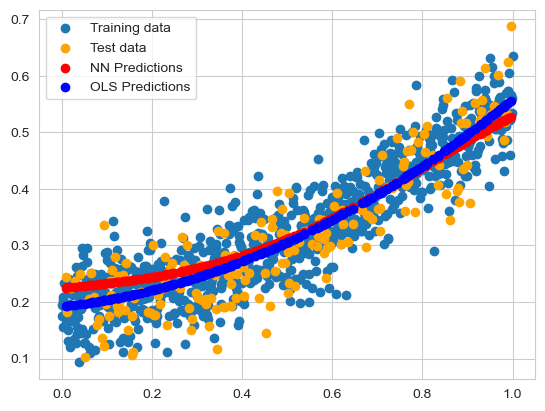

In [16]:
plt.figure()
plt.scatter(train_X[:,0], train_target, label='Training data')
plt.scatter(test_X[:,0], test_target, color='orange', label='Test data')
plt.scatter(test_X[:,0], predictions, color='red', label='NN Predictions')
plt.scatter(test_X[:,0], OLS_pred, color='blue', label='OLS Predictions')
plt.legend()

In [18]:
print(f'NN MSE: ', NN_test_mse)
print(f'OLS MSE: ', mean_squared_error(OLS_pred, test_target))

print('NN R2 score: ', NN_test_r2)
print('OLS R2 score:' , r2_score(OLS_pred, test_target))

NN MSE:  0.0033309650607407093
OLS MSE:  0.0028435194
NN R2 score:  0.78909238962266
OLS R2 score: 0.7621408000881299


We see that, even for this randomly selected model architecture, the NN performs similar to the OLS regression. The advantage linked to the NN compared to regression will be further amplified when we move to more complex datasets with more intertwined relations.

# Model evaluation: Model selection and tuning

The nature of the neural network models is one of high number of unknown parameters. Assuming that there are a true *best parameter* for each task this leads to a high demand for parameter tuning. In the case of 1D regression we have a training process with low computational cost allowing us to perform a grid search for the optimal parameters, rather than a random search. (figure 11.2 (p.421) in the book).

When it comes to variables where we, as the practitionars, have a deciding point we have the following factors/tunable features (not neccesaraly ordered by importance):

**Hyper-Parameters of the Model and Training Criterion:**
- Number of hidden layers
- Number of nodes in each hidden layer
- Regularization with weight decay
    - L1
    - L2
- Weight and bias initialization
- Activation function for hidden layers (output layer is linear in the regression task)


**Training spesific support features:**
- Optimizer
    - Learning rate
        - Learning rate decay
    - Momentum
    - other hyperparameters

- Parameters connected to iterations
    - Number of epochs
    - Batch size
    - number of training iterations
        - early stopping
- Other Regularization terms
    - Dropout

**Other:**
- Cost function 
- Data preprocessing
- Seeds

In order to tie their importance back to the model we have to remind ourselves with the actual task requirments:
> The task is to predict the value of a continuous variable given a set of predictors.
> We which to meet this task by deep learning in our neural network model based on a training set.
> The tuned model should be able to generalize to unseen data that is assumed to be described by the same function. 

We will therefor assess the learning algorithm based on ability to:
1. Make the training error small (dlbook p. 108): Here we asses the models ability to fit the training data using a *cost function*.
2. Make the gap between training and test error small (dlbook p. 108): Here we asses the models ability to generalize to unseen data using a *cost function*.

And so, the consequences of our feature selection is if wrongfully chosen we might end up with a model that is not able to generalize to unseen data. Following that tread; in order to get a model that is not overfitted and that leaves the test set unseen we will perform the model tuning on a validation set generated from the training set. This is done by splitting the training set into a training set and a validation set in a 80/20 split. Further, since the sample size is scarce for later datasets we will use k-fold cross validation on the training set.

In the following sections we will investigate and account for the different features and their importance for the model.

## Set up data for model hyperparameter tuning, training and test prediction

A key principle of ML algorythms is to try to create a model which is able to generalize to unseen data. This is done by splitting the data into a training set and a test set. The training set is used to train the model and the test set is used to test the model. The test set is unseen to the model during training. This is done to avoid overfitting. 

We perform here our test train split, further we split the training set into a training an validation set where the validation set is used for hyperparameter tuning. When the model is tuned we will retrain the model on the whole training set and test the model on the test set. It is important to note that as the whole training set is used for the cross validation the training error will underestimate the generalization error. 

In [19]:
true_a = torch.tensor([2, 0.5, 3.2])

n = 1000

x = torch.linspace(0, 1, n)
degree = 2
X_OLS = make_design_matrix(x, degree)
x = x.reshape(-1, 1)
target = ((torch.tensor([true_a[0] + true_a[1]*x + true_a[2]*x**2 for x in x]) + .5 * torch.randn(n)) * 1e-1).reshape(-1, 1)

# Making a design matrix to use for linear regression part


train_X, test_X, train_X_OLS, test_X_OLS, train_target, test_target = train_test_split(x, X_OLS, target, test_size=0.2)

train_target = train_target.reshape(-1, 1)
test_target = test_target.reshape(-1, 1)

## Hyperparameter tuning

We will not tune all the hyperparameters listed previously. Further we use a grid search for the hyperparameters. This is done since the sample size is small and the computational cost is low. Lastly we will tune one set of parameters, keep the "optimal" ones and tune the next set. This is done to avoid the curse of dimensionality and to ease the interpretation of the results. We use a standard model as a starting point for both the PyTorch implementation and the self written FFNN. This is done to have a reference point for the tuning.

The starting model is:
- Number of hidden layers: 2
- Number of nodes in each hidden layer: 4
- Number of output nodes: 1
- Activation function for hidden layers: Sigmoid
- Learning rate: 0.01
- L2 regularization: 0.0001

### Parameters connected to iterations

For our tuning journey we will start with the parameters connected to iterations. These are the number of epochs, the batch size and reularization in terms of early stopping.

The number of total iterations and early stopping is used in order to regularize the model. This is done to avoid overfitting. As we here are compairing the PyTorch implementation with the self written FFNN we will not use early stopping. This is because the self written FFNN does not have this feature implemented. This may tho be viewed as a sub optimal choice and one that might lead to overfitting.

The number of epochs is the number of times we pass through the entire dataset. The batch size is the number of samples used in each iteration. 

We start by defining the standard model:

In [20]:
n_hidden_layers = 2
n_hidden_nodes = 4
n_outputs = 1
n_features = x.shape[1]
activation_hidden = 'sigmoid'
learning_rate = 0.01
l2_reg = 0.0001

We then define the hyperparameter space for the grid search:

In [21]:
n_epochs_space = [50, 100, 150]
minibatches_size_space = [8, 16, 32, 64]

Performe grid search with K-fold cross validation:

In [22]:
# Initialize the evaluation metrices
mse = np.zeros((len(n_epochs_space), len(minibatches_size_space)))
r2 = np.zeros((len(n_epochs_space), len(minibatches_size_space)))
mse_train = np.zeros((len(n_epochs_space), len(minibatches_size_space)))
r2_train = np.zeros((len(n_epochs_space), len(minibatches_size_space)))

# Initialize the k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Loop over the hyperparameter spaces
for i, num_epochs in enumerate(n_epochs_space):
    print(f"Number of epochs: {num_epochs}")
    for j, num_batches in enumerate(minibatches_size_space):
        print(f"Number of minibatches: {num_batches}")
        mse_crossval = []
        r2_crossval = []
        mse_train_crossval = []
        r2_train_crossval = []
        # Loop over the folds
        for train_idx, val_idx in kf.split(train_X):
            # Extract training and validation data
            X_train, target_train = train_X[train_idx], train_target[train_idx]
            X_val, target_val = train_X[val_idx], train_target[val_idx]
            
            # Create new network
            ffnn = Neural_Network_PyTorch(n_features, 
                                          n_hidden_layers, n_hidden_nodes, 
                                          n_outputs, 
                                          activation_function_hidden_layers=activation_hidden, 
                                          activation_function_output_layer=None)
            
            # Loss function
            criterion = nn.MSELoss()
            # Optimizer
            optimizer = optim.Adam(ffnn.parameters(), lr=learning_rate, weight_decay=l2_reg)
            
            # Train the network            
            ffnn = ffnn.train_network(X_train, target_train, 
                                      optimizer, criterion,
                                      num_iter=num_epochs, n_minibatches=num_batches)
            
            target_train_pred = ffnn.feed_forward(X_train)
            mse_train_crossval.append(float(criterion(target_train_pred, target_train)))
            r2_train_crossval.append(r2_score(target_train, target_train_pred.detach().numpy()))
            # Evaluate the network
            ffnn.eval() # set model in evaluation mode
            with torch.no_grad(): # disable gradient computation
                target_val_pred = ffnn.feed_forward(X_val)
                mse_val_cv = float(criterion(target_val_pred, target_val))
                mse_crossval.append(mse_val_cv)
                r2_crossval.append(r2_score(target_val, target_val_pred))
        
        mse[i][j] = np.mean(mse_crossval)
        r2[i][j] = np.mean(r2_crossval)
        mse_train[i][j] = np.mean(mse_train_crossval)
        r2_train[i][j] = np.mean(r2_train_crossval)

Number of epochs: 50
Number of minibatches: 8
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000015203DF19E0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000015203C7B560>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001520362BB00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000015203DF19E0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000015203C7B560>
Number of minibatches: 16
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001520362BB00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000015203DF19E0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000015203C7B560>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001520362BB00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy a

In [27]:
print(r2)

[[0.38705395 0.72194248 0.74525278 0.78752501]
 [0.71080933 0.70148581 0.78112608 0.77559513]
 [0.71899427 0.77275045 0.75094003 0.72882033]]


In [42]:
def plot_heatmaps(metric_data, 
                  x_label, y_label,
                  x_ticks_labels, y_ticks_labels,
                  with_train=True):
    
    # Get limits for the heatmaps
    max_mse = np.max([np.max(metric_data[0][0]), np.max(metric_data[0][1])]) if with_train else np.max(metric_data[0][0])
    min_mse = np.min([np.min(metric_data[0][0]), np.min(metric_data[0][1])]) if with_train else np.min(metric_data[0][0])
    if with_train:
        min_mse_diff = np.min(metric_data[0][2])
        max_mse_diff = np.max(metric_data[0][2])
        min_r2_diff = np.min(metric_data[1][2])
        max_r2_diff = np.max(metric_data[1][2])
    
        fig, ax = plt.subplots(2, 3, figsize = (15, 12), sharex = True, sharey = True)
        data_names = ["Training", "Validation", "Training-Validation"]

    else:
        fig, ax = plt.subplots(2, 1, figsize = (5, 12), sharex = True, sharey = True)
        data_names = ["Validation"]
        
    for row, metric_name in enumerate(["Mean-Squared Error", r"R$^2$"]):
        for (col, data_name), data in zip(enumerate(data_names), 
                                          metric_data[row]):
            if col == 2:
                cmap = "RdBu_r"
                if row == 1:
                    upper = max_r2_diff
                    lower = min_r2_diff
                else:
                    upper = max_mse_diff
                    lower = min_mse_diff
            else:
                cmap = "viridis"
                if row == 1:
                    upper = 1
                    lower = 0
                else:
                    upper = max_mse
                    lower = min_mse
                    
            axis = ax[row, col] if with_train else ax[row]

            heatmap = sns.heatmap(data, annot=True, 
                                  ax=axis, 
                                  cmap=cmap, 
                                  vmin=lower, vmax=upper)
            heatmap.set_xticklabels(x_ticks_labels)
            heatmap.set_yticklabels(y_ticks_labels)
            
            axis.set_title(metric_name+" "+data_name)
            axis.set_ylabel(y_label)
            axis.set_xlabel(x_label)
            

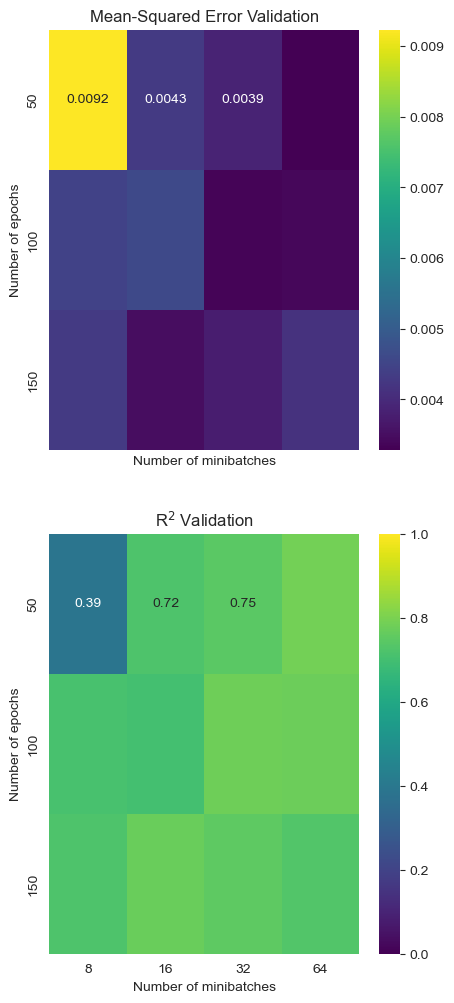

In [43]:
# Collect performance metrics data
metric_data = [[mse], 
               [r2]]
# Plot heatmaps
plot_heatmaps(metric_data, 
              'Number of minibatches', 'Number of epochs',
              minibatches_size_space, n_epochs_space,
              with_train=False)

While the number of epoch will dictate how much training we can perform and thus can reduce the training error it can also lead to overfitting when there are no early stopping integrated in the algorythm. Investigating this we subtract the validation metric from the training to find the difference. We see that the difference is small and thus we do not have to worry about overfitting.

We choose the model with the lowest validation error, that is: 
- **100 epochs** 
- **32 minibatches**

We will use this configuration moving forward. 

## Model architecture

In a neural network the *capacity* of the model is determined by the model architecture. Here we refer to capacity as the ability to learn complex relations leading to a correct mapping. Some examples (with informal notation) are: $X \mapsto \{True, False\} / \{0, 1\}$ or $X \mapsto \mathbf{y}\in\mathbb{R}$ where $\mapsto$ denotes "*maps to*". 

In general, the learning algorythm will, under our assessment criterions perform better with a model capacity mathched with the complexity of the task (dlb). From this the questions arises: what if there is a mismatch? 
- In the case of a model with too low capacity, the model will not be able to learn the task. This is refeered to as *underfitting*.  
- In the case of a model with too high capacity, the model will be able to learn the task, but will not be able to generalize to unseen data. This is refeered to as *overfitting*.

We can identify the model capacity by assessment criterion 2. "how large is the gap between the training and the test error?".

### Number of hidden layers and nodes

One way to increase the model capacity is to increase the number of hidden layers. Even tho we by the "... approximation theorem" strictly can learn the relations by one layer only with many nodes, we might need more layers to learn the relations with higher accuracy. And so, the need for a high number of hidden layers is not a given, but should be investigated in parallell with the number of nodes in each layer. This means that this is a matter of tuning the model architecture depending on the model complexity. 

We here choose to move on with **2 hidden layers** the same size, since a pyramid shape has been shown to in general not increase generalization performance. We will investigate the number of nodes in each layer under section "Grid search for "untuned" features".


### Regularization with weight decay

Regularization is a technique used to reduce the generalization error. This is done by adding a penalty term to the cost function. The penalty term is a function of the weights and biases. We will here use the L2 regularization. We will tune this value in the hyperparmeter space of $\lambda = \{10^{n} | n \in \{-5, -4, ... -2\}\}$.   

### Activation functions

The role of the activation function is discussed in ... . The activation function for the output layer is linear since we are performing a regression task. Further when we look at the activation function for the hidden layers we have a choice between sigmoid and ReLU. We choose here the sigmoid  activation function while tuning without investigating the performance. Later we investigate the performance of alternative activation functions. We expect the choice will land on the ReLU function. This is because the ReLU function is more robust since it does not suffer from the vanishing gradient problem. Further it is more efficient since it is computationally less expensive as a result from the section wise linearity. However, this might not be the case as the model capacity is quite small. 

## Training specific support features

### Cost function

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

During training we assess the performance of the model by the cost function. This quantification of the error sets the direction of model adjustment and so a wrongfull selection of cost function, might reduce the prediction ability of the NN. It is therefor of high importance to know the data and the task at hand, before selecting the cost function. In our case the task at hand is a regression task. Further we know that the mean will be a good measure of central tendency for the errors since the errors are indeed generated around a standard normal distribution. We will therefor use the *mean* squared error as cost function. If we, while investigating a tru dataset found a skewed distribution of the errors the MSE might not be the best selection for cost function. Then the selection will be partly dictated by our which to favour outliers or not. If we do not wish to favour outliers we might use the *median* as better measure of central tendency. And choose cost functions accordingly. 

To conclude: we again choose the MSE as cost function since we know the errors are generated around a standard normal distribution.

### Optimizer

The optimizer is the algorithm that performs the gradient descent in the NN backpropagation. As displayed in a) we saw that the gradient descent is performed in steps towards the minimum of the cost function. 

The two most widely used optimizers is the Adam and the SGD with Nesterov momentum. We will use the Adam optimizer throughout our PyTorch implementation of the NN. The adam optimizer is an adaptive optimizer, meaning that it adapts the learning rate during training. This is done by using the first and second moments of the gradients. The first moment is the mean of the gradients and the second moment is the uncentered variance of the gradients. The Adam optimizer uses these moments to adapt the learning rate. The Adam optimizer is therefor more efficient than the SGD in most applications. 
https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20is%20an%20optimization%20algorithm%20that,weights%20iterative%20based%20in%20training%20data.&text=Adam%20is%20an%20optimization,based%20in%20training%20data.&text=an%20optimization%20algorithm%20that,weights%20iterative%20based%20in 

https://arxiv.org/abs/1412.6980
https://arxiv.org/abs/1609.04747

This optimizer still has some hyperparameters to be tuned. Here under we have the learning rate, $\beta_1$, $\beta_2$ and $\varepsilon$. We will only perform configuration of the learning rate as it has the largest impact on the performance of the optimizer. The other hyperparameters are set to their default values suggested in https://arxiv.org/abs/1412.6980. 



### Learning rate

The learning rate dictates the size of the steps taken in the gradient descent done by the optimizer. If the learning rate is too large the model might not converge. If the learning rate is too small the model might converge too slowly.
 
The learning rate has been shown to be the single most influencial hyperparameter, we will therefor tune the learning rate in the hyperparameter space of $\{10^{n} | n \in \{-4, ... 0\}\}$.

## Other hyperparameters

The other hyperparameters available for tuning will not be investigated in this project. 

## Grid search for the "untuned" features. 

#### Investigating NN architecture: number of hidden nodes grid search

Let us perform a grid search with confined to hidden layers 2 and nodes in each layer in the set $\{2, 4, 6, 8, 10, 12\}$. We will use the same training parameters as done in the previous section with our updated epoch and minibatch number.

Let's start by defining the standard model:

In [32]:
num_hidden_layers_space = [2,]
n_hidden_nodes_space = [2, 4, 6, 8, 10, 12]
n_outputs = 1
n_features = x.shape[1]
activation_hidden = 'sigmoid'
learning_rate = 0.01
l2_reg = 0.0001
num_epochs = 100
n_minibatches = 32

Performe grid search with K-fold cross validation:

In [126]:
# Initialize the evaluation metrices
mse = np.zeros((len(num_hidden_layers_space), len(n_hidden_nodes_space)))
r2 = np.zeros((len(num_hidden_layers_space), len(n_hidden_nodes_space)))
mse_train = np.zeros((len(num_hidden_layers_space), len(n_hidden_nodes_space)))
r2_train = np.zeros((len(num_hidden_layers_space), len(n_hidden_nodes_space)))

# Initialize the k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Loop over the hyperparameter spaces
for i, num_hidden_layers in enumerate(num_hidden_layers_space):
    print(f"Number of hidden layers: {num_hidden_layers}")
    for j, n_hidden_nodes in enumerate(n_hidden_nodes_space):
        print(f"Number of hidden nodes per layer: {n_hidden_nodes}")
        mse_crossval = []
        r2_crossval = []
        mse_train_crossval = []
        r2_train_crossval = []
        # Loop over the folds
        for train_idx, val_idx in kf.split(train_X):
            # Extract training and validation data
            X_train, target_train = train_X[train_idx], train_target[train_idx]
            X_val, target_val = train_X[val_idx], train_target[val_idx]
            
            # Create new network
            ffnn = Neural_Network_PyTorch(n_features, 
                                          n_hidden_layers, n_hidden_nodes, 
                                          n_outputs, 
                                          activation_function_hidden_layers=activation_hidden, 
                                          activation_function_output_layer=None)
            
            # Loss function
            criterion = nn.MSELoss()
            # Optimizer
            optimizer = optim.Adam(ffnn.parameters(), lr=learning_rate, weight_decay=l2_reg)
            
            # Train the network            
            ffnn = ffnn.train_network(X_train, target_train, 
                                      optimizer, criterion,
                                      num_iter=num_epochs, n_minibatches=n_minibatches)
            # Evaluate the network
            # Train performance
            target_train_pred = ffnn.feed_forward(X_train)
            mse_train_crossval.append(float(criterion(target_train_pred, target_train)))
            r2_train_crossval.append(r2_score(target_train, target_train_pred.detach().numpy()))
            # Validation performance
            ffnn.eval() # set model in evaluation mode
            with torch.no_grad(): # disable gradient computation
                target_val_pred = ffnn.feed_forward(X_val)
                mse_val_cv = float(criterion(target_val_pred, target_val))
                mse_crossval.append(mse_val_cv)
                r2_crossval.append(r2_score(target_val, target_val_pred))
        
        mse[i][j] = np.mean(mse_crossval)
        r2[i][j] = np.mean(r2_crossval)
        mse_train[i][j] = np.mean(mse_train_crossval)
        r2_train[i][j] = np.mean(r2_train_crossval)

Number of hidden layers: 2
Number of hidden nodes per layer: 2
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6E47BBA0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC663ECEA0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6E47BBA0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC663ECEA0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6E47BBA0>
Number of hidden nodes per layer: 4
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6F4A0360>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6E47BBA0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6F4A2520>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6E47BBA0>
<function Neural_Network_PyTorch.set_activatio

In [134]:
print(r2)

[[0.73055817 0.76366347 0.77840615 0.68442335 0.71447334 0.72805027]]


In [30]:
metric_data = [[np.array(mse), np.array(mse_train), np.array(mse_train-mse)], 
               [np.array(r2), np.array(r2_train), np.array(r2_train-r2)]]
# Plot heatmaps
plot_heatmaps(metric_data, 
              "Number of hidden nodes", "Number of hidden layers",
              n_hidden_nodes_space, num_hidden_layers_space)

NameError: name 'n_hidden_nodes_space' is not defined

We see that the model with **2 hidden layers** and **6 nodes** in each layer performs best. We will therefor use this model moving forward.

### Investigate the L2 regularization and learning rate

define model architecture:

In [138]:
num_hidden_layers = 2
n_hidden_nodes = 6
n_outputs = 1
n_features = x.shape[1]
activation_hidden = 'sigmoid'
learning_rate_space = np.logspace(-4, 0, 5)
l2_reg_space = np.logspace(-5, -2, 4)
num_epochs = 50
n_minibatches = 32

Performe grid search with K-fold cross validation:

In [139]:
# Initialize the evaluation metrices
mse = np.zeros((len(learning_rate_space), len(l2_reg_space)))
r2 = np.zeros((len(learning_rate_space), len(l2_reg_space)))
mse_train = np.zeros((len(learning_rate_space), len(l2_reg_space)))
r2_train = np.zeros((len(learning_rate_space), len(l2_reg_space)))

# Initialize the k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Loop over the hyperparameter spaces
for i, learning_rate in enumerate(learning_rate_space):
    print(f"Learning rate: {learning_rate}")
    for j, l2_reg in enumerate(l2_reg_space):
        print(f"L2 regularization: {l2_reg}")
        mse_crossval = []
        r2_crossval = []
        mse_train_crossval = []
        r2_train_crossval = []
        # Loop over the folds
        for train_idx, val_idx in kf.split(train_X):
            # Extract training and validation data
            X_train, target_train = train_X[train_idx], train_target[train_idx]
            X_val, target_val = train_X[val_idx], train_target[val_idx]
            
            # Create new network
            ffnn = Neural_Network_PyTorch(n_features, 
                                          n_hidden_layers, n_hidden_nodes, 
                                          n_outputs, 
                                          activation_function_hidden_layers=activation_hidden, 
                                          activation_function_output_layer=None)
            
            # Loss function
            criterion = nn.MSELoss()
            # Optimizer
            optimizer = optim.Adam(ffnn.parameters(), lr=learning_rate, weight_decay=l2_reg)
            
            # Train the network            
            ffnn = ffnn.train_network(X_train, target_train, 
                                      optimizer, criterion,
                                      num_iter=num_epochs, n_minibatches=n_minibatches)
            # Evaluate the network
            # Train performance
            target_train_pred = ffnn.feed_forward(X_train)
            mse_train_crossval.append(float(criterion(target_train_pred, target_train)))
            r2_train_crossval.append(r2_score(target_train, target_train_pred.detach().numpy()))
            # Validation performance
            ffnn.eval() # set model in evaluation mode
            with torch.no_grad(): # disable gradient computation
                target_val_pred = ffnn.feed_forward(X_val)
                mse_val_cv = float(criterion(target_val_pred, target_val))
                mse_crossval.append(mse_val_cv)
                r2_crossval.append(r2_score(target_val, target_val_pred))
        
        mse[i][j] = np.mean(mse_crossval)
        r2[i][j] = np.mean(r2_crossval)
        mse_train[i][j] = np.mean(mse_train_crossval)
        r2_train[i][j] = np.mean(r2_train_crossval)

Learning rate: 0.0001
L2 regularization: 1e-05
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6E2976A0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC663EE0C0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6E296340>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC663EE0C0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6E2976A0>
L2 regularization: 0.0001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC663EE0C0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6E296B60>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC663EE0C0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AC6E2976A0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy 

In [141]:
r2

array([[-1.3403738 , -2.47580144, -1.10141308, -0.12915922],
       [ 0.24668604,  0.10930482,  0.08410852, -0.01409109],
       [ 0.78016872,  0.73623821,  0.63701483, -0.38576913],
       [ 0.59196616,  0.65042137, -0.43932677, -1.75519457],
       [-1.87855855, -0.82514977, -1.68789821, -1.77937456]])

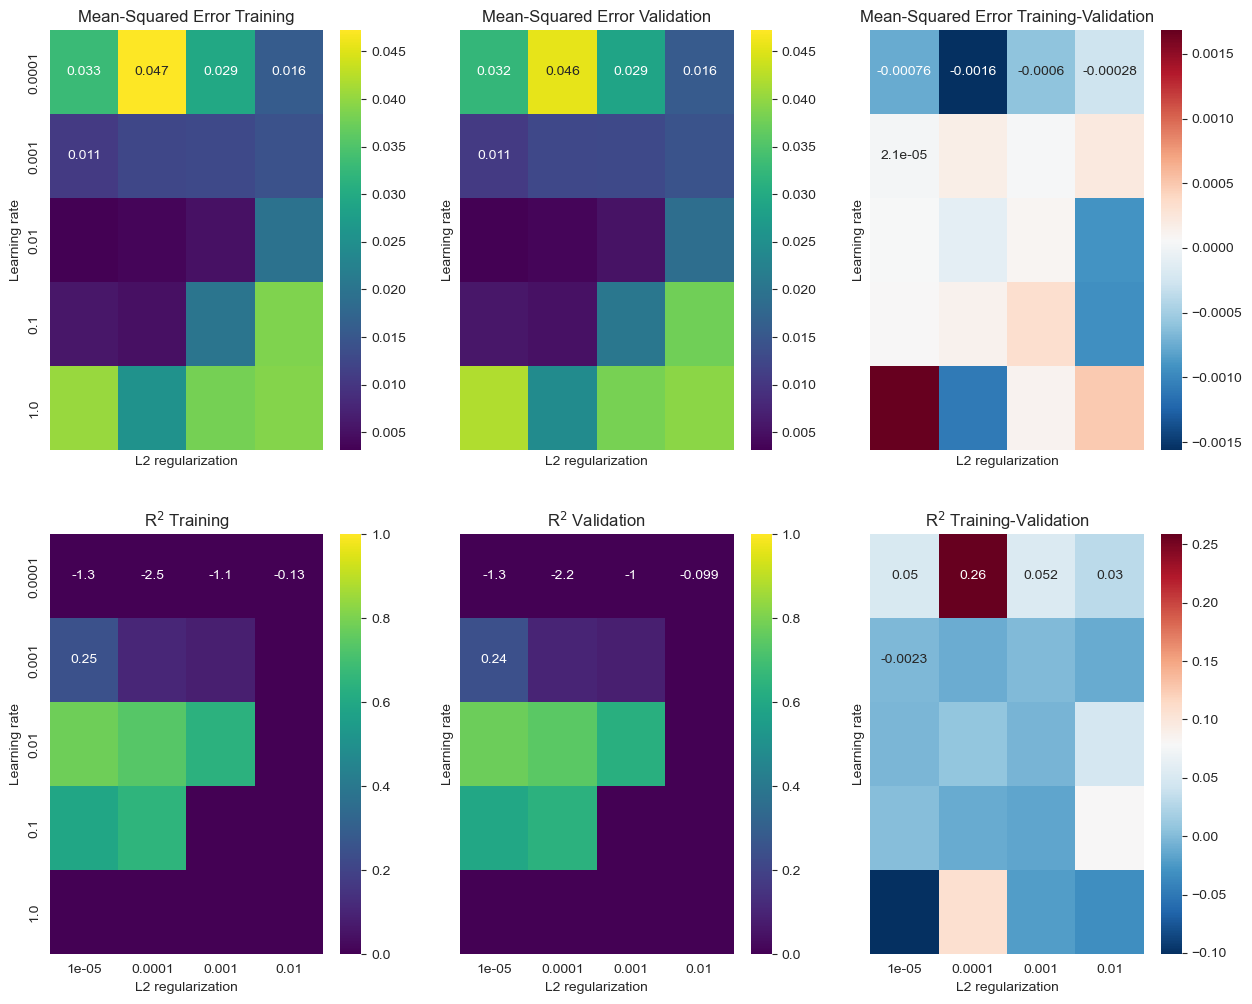

In [140]:
metric_data = [[mse, mse_train, mse_train-mse], 
               [r2, r2_train, r2_train-r2]]
plot_heatmaps(metric_data, 
              "L2 regularization", "Learning rate",
              l2_reg_space, learning_rate_space)

## Investigating the activation functions for hidden layers

In [186]:
num_hidden_layers = 2
n_hidden_nodes = 6
n_outputs = 1
n_features = x.shape[1]
activation_hidden_space = ['sigmoid', 'ReLU', 'tanh', 'LeakyReLU']
learning_rate = np.logspace(-4, 0, 5)
l2_reg = 10e-5
num_epochs = 50
n_minibatches = 32